In [24]:
import numpy as np
import pandas as pd
import os

In [25]:
# For CUDA 10.2
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu102

Looking in indexes: https://download.pytorch.org/whl/cu102


In [26]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [27]:
print(torch.__version__)
print(torch.version.cuda)

2.4.0
12.3


In [28]:
!pip install pycocotools
from pycocotools.coco import COCO

In [29]:
from albumentations.pytorch import ToTensorV2

In [30]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [31]:
class DroneDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [32]:
dataset_path = "/kaggle/input/drone-detection/coco json drone detection"

In [33]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


{0: {'id': 0, 'name': 'drone', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'AirPlane', 'supercategory': 'drone'},
 2: {'id': 2, 'name': 'Drone', 'supercategory': 'drone'},
 3: {'id': 3, 'name': 'Helicopter', 'supercategory': 'drone'}}

In [34]:
classes = [i[1]['name'] for i in categories.items()]
classes

['drone', 'AirPlane', 'Drone', 'Helicopter']

In [35]:
train_dataset = DroneDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


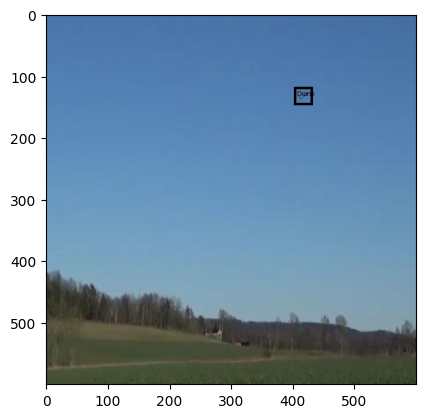

In [36]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [37]:
len(train_dataset)

8820

In [38]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [40]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [41]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [42]:
device = torch.device("cuda")

In [43]:
model = model.to(device)

In [44]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [45]:
import sys
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

metrics={'epochs':[],'loss':[]}
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

    metrics['loss'].append(np.mean(all_losses))
    metrics['epochs'].append(epoch)

In [46]:
num_epochs=30

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 2205/2205 [03:31<00:00, 10.43it/s]


Epoch 0, lr: 0.010000, loss: 0.703517, loss_classifier: 0.291186, loss_box: 0.404820, loss_rpn_box: 0.002359, loss_object: 0.005151


100%|██████████| 2205/2205 [03:22<00:00, 10.87it/s]


Epoch 1, lr: 0.010000, loss: 0.691406, loss_classifier: 0.252442, loss_box: 0.433023, loss_rpn_box: 0.002040, loss_object: 0.003901


100%|██████████| 2205/2205 [03:21<00:00, 10.94it/s]


Epoch 2, lr: 0.010000, loss: 0.676905, loss_classifier: 0.241368, loss_box: 0.429865, loss_rpn_box: 0.001969, loss_object: 0.003703


100%|██████████| 2205/2205 [03:21<00:00, 10.93it/s]


Epoch 3, lr: 0.010000, loss: 0.710605, loss_classifier: 0.245169, loss_box: 0.459979, loss_rpn_box: 0.001922, loss_object: 0.003535


100%|██████████| 2205/2205 [03:22<00:00, 10.90it/s]


Epoch 4, lr: 0.010000, loss: 0.690542, loss_classifier: 0.236901, loss_box: 0.448283, loss_rpn_box: 0.001876, loss_object: 0.003482


100%|██████████| 2205/2205 [03:22<00:00, 10.90it/s]


Epoch 5, lr: 0.010000, loss: 0.690443, loss_classifier: 0.241327, loss_box: 0.443313, loss_rpn_box: 0.001917, loss_object: 0.003885


100%|██████████| 2205/2205 [03:21<00:00, 10.97it/s]


Epoch 6, lr: 0.010000, loss: 0.715781, loss_classifier: 0.236913, loss_box: 0.473818, loss_rpn_box: 0.001830, loss_object: 0.003220


100%|██████████| 2205/2205 [03:20<00:00, 11.00it/s]


Epoch 7, lr: 0.010000, loss: 0.708501, loss_classifier: 0.232945, loss_box: 0.470571, loss_rpn_box: 0.001795, loss_object: 0.003190


100%|██████████| 2205/2205 [03:19<00:00, 11.04it/s]


Epoch 8, lr: 0.010000, loss: 0.703110, loss_classifier: 0.233339, loss_box: 0.464754, loss_rpn_box: 0.001784, loss_object: 0.003232


100%|██████████| 2205/2205 [03:19<00:00, 11.07it/s]


Epoch 9, lr: 0.010000, loss: 0.704075, loss_classifier: 0.229977, loss_box: 0.469408, loss_rpn_box: 0.001731, loss_object: 0.002959


100%|██████████| 2205/2205 [03:21<00:00, 10.94it/s]


Epoch 10, lr: 0.010000, loss: 0.703483, loss_classifier: 0.224358, loss_box: 0.474426, loss_rpn_box: 0.001680, loss_object: 0.003019


100%|██████████| 2205/2205 [03:21<00:00, 10.92it/s]


Epoch 11, lr: 0.010000, loss: 0.707618, loss_classifier: 0.228382, loss_box: 0.474568, loss_rpn_box: 0.001692, loss_object: 0.002976


100%|██████████| 2205/2205 [03:18<00:00, 11.09it/s]


Epoch 12, lr: 0.010000, loss: 0.714233, loss_classifier: 0.230619, loss_box: 0.479060, loss_rpn_box: 0.001673, loss_object: 0.002882


100%|██████████| 2205/2205 [03:19<00:00, 11.06it/s]


Epoch 13, lr: 0.010000, loss: 0.684867, loss_classifier: 0.219716, loss_box: 0.460506, loss_rpn_box: 0.001641, loss_object: 0.003004


100%|██████████| 2205/2205 [03:18<00:00, 11.11it/s]


Epoch 14, lr: 0.010000, loss: 0.702845, loss_classifier: 0.227573, loss_box: 0.470820, loss_rpn_box: 0.001644, loss_object: 0.002808


100%|██████████| 2205/2205 [03:19<00:00, 11.06it/s]


Epoch 15, lr: 0.010000, loss: 0.692356, loss_classifier: 0.226440, loss_box: 0.461107, loss_rpn_box: 0.001718, loss_object: 0.003092


100%|██████████| 2205/2205 [03:18<00:00, 11.10it/s]


Epoch 16, lr: 0.010000, loss: 0.694169, loss_classifier: 0.222627, loss_box: 0.466866, loss_rpn_box: 0.001653, loss_object: 0.003023


100%|██████████| 2205/2205 [03:18<00:00, 11.12it/s]


Epoch 17, lr: 0.010000, loss: 0.704008, loss_classifier: 0.225165, loss_box: 0.474389, loss_rpn_box: 0.001632, loss_object: 0.002823


100%|██████████| 2205/2205 [03:19<00:00, 11.08it/s]


Epoch 18, lr: 0.010000, loss: 0.699022, loss_classifier: 0.223600, loss_box: 0.471033, loss_rpn_box: 0.001636, loss_object: 0.002753


100%|██████████| 2205/2205 [03:18<00:00, 11.11it/s]


Epoch 19, lr: 0.010000, loss: 0.678210, loss_classifier: 0.216552, loss_box: 0.457340, loss_rpn_box: 0.001613, loss_object: 0.002706


100%|██████████| 2205/2205 [03:19<00:00, 11.07it/s]


Epoch 20, lr: 0.010000, loss: 0.689712, loss_classifier: 0.222820, loss_box: 0.462339, loss_rpn_box: 0.001634, loss_object: 0.002920


100%|██████████| 2205/2205 [03:18<00:00, 11.09it/s]


Epoch 21, lr: 0.010000, loss: 0.676807, loss_classifier: 0.215332, loss_box: 0.457077, loss_rpn_box: 0.001605, loss_object: 0.002792


100%|██████████| 2205/2205 [03:17<00:00, 11.16it/s]


Epoch 22, lr: 0.010000, loss: 0.700297, loss_classifier: 0.220805, loss_box: 0.474988, loss_rpn_box: 0.001582, loss_object: 0.002922


100%|██████████| 2205/2205 [03:18<00:00, 11.12it/s]


Epoch 23, lr: 0.010000, loss: 0.672920, loss_classifier: 0.208277, loss_box: 0.460334, loss_rpn_box: 0.001563, loss_object: 0.002746


100%|██████████| 2205/2205 [03:18<00:00, 11.10it/s]


Epoch 24, lr: 0.010000, loss: 0.669493, loss_classifier: 0.213136, loss_box: 0.451900, loss_rpn_box: 0.001574, loss_object: 0.002884


100%|██████████| 2205/2205 [03:18<00:00, 11.12it/s]


Epoch 25, lr: 0.010000, loss: 0.674196, loss_classifier: 0.212788, loss_box: 0.457125, loss_rpn_box: 0.001535, loss_object: 0.002749


100%|██████████| 2205/2205 [03:18<00:00, 11.11it/s]


Epoch 26, lr: 0.010000, loss: 0.659894, loss_classifier: 0.207762, loss_box: 0.447836, loss_rpn_box: 0.001541, loss_object: 0.002755


100%|██████████| 2205/2205 [03:20<00:00, 11.02it/s]


Epoch 27, lr: 0.010000, loss: 0.666003, loss_classifier: 0.209807, loss_box: 0.451690, loss_rpn_box: 0.001575, loss_object: 0.002931


100%|██████████| 2205/2205 [03:19<00:00, 11.07it/s]


Epoch 28, lr: 0.010000, loss: 0.639960, loss_classifier: 0.201527, loss_box: 0.434159, loss_rpn_box: 0.001551, loss_object: 0.002724


100%|██████████| 2205/2205 [03:22<00:00, 10.91it/s]

Epoch 29, lr: 0.010000, loss: 0.627768, loss_classifier: 0.197744, loss_box: 0.425688, loss_rpn_box: 0.001556, loss_object: 0.002780


In [54]:
model.eval()
torch.cuda.empty_cache()

In [48]:
def iou_score(loader):
    scores=[]
    n=0
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        n+=len(images)
        try:
            x_target_min,y_target_min,x_target_max,y_target_max=targets[0]['boxes'].tolist()[0]
        except:
            continue
        
        prediction = model(images)
        pred = prediction[0]

        try:
            x_min,y_min,x_max,y_max=pred['boxes'][pred['scores'] > 0.8].tolist()[0]
        except:
            continue

        inter_x_min = max(x_min, x_target_min)
        inter_y_min = max(y_min, y_target_min)
        inter_x_max = min(x_max, x_target_max)
        inter_y_max = min(y_max, y_target_max)

        inter_width = max(0, inter_x_max - inter_x_min + 1)
        inter_height = max(0, inter_y_max - inter_y_min + 1)
        intersection_area = inter_width * inter_height

        box1_area = (x_max - x_min + 1) * (y_max - y_min + 1)
        box2_area = (x_target_max - x_target_min + 1) * (y_target_max - y_target_min + 1)

        union_area = box1_area + box2_area - intersection_area

        if union_area == 0:
            score+=0

        scores.append(intersection_area / union_area)

    return sum(scores)/len(scores)
print(iou_score(train_loader))

100%|██████████| 2205/2205 [02:32<00:00, 14.45it/s]

0.7701271545062515


In [49]:
test_dataset = DroneDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [50]:
img, _ = test_dataset[100]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

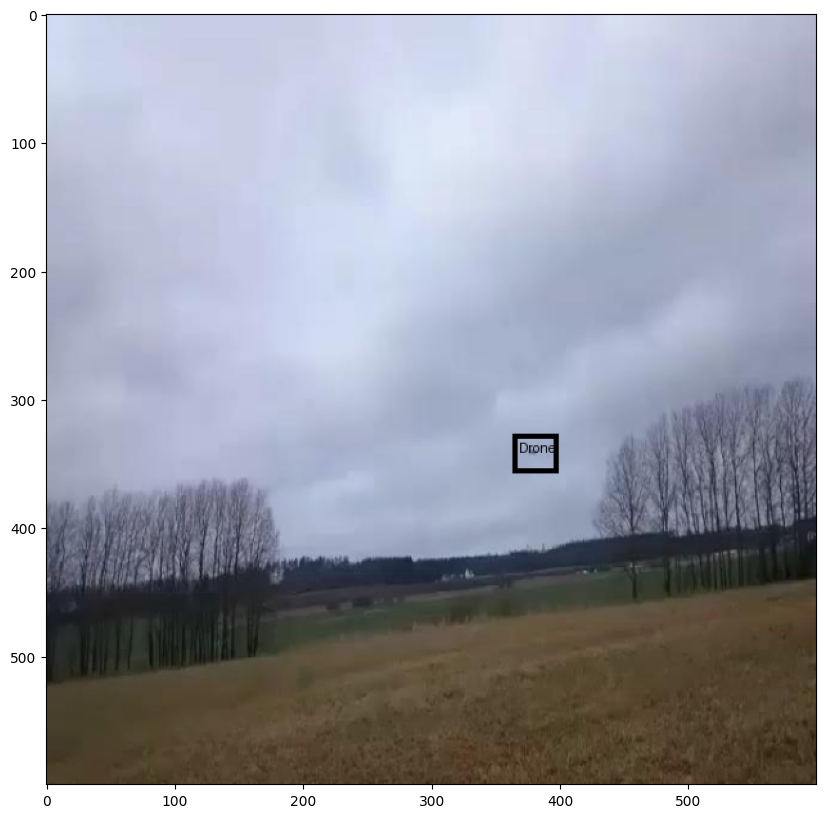

In [51]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

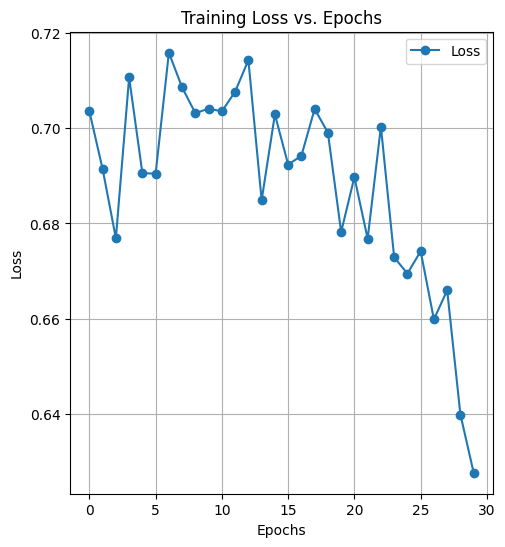

In [52]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(metrics['epochs'], metrics['loss'], marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid()
plt.legend()
